In [1]:
# Install necessary packages
!pip install rdkit
!pip install duckdb
!pip install pandas networkx
!pip install torch
!pip install torch-geometric

# Import libraries
import numpy as np 
import pandas as pd 
import duckdb
from torch.utils.data import Dataset
from rdkit import Chem
from rdkit.Chem import AllChem
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.preprocessing import LabelEncoder
import networkx as nx
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.model_selection import KFold


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 63.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.8 MB/s eta 0:00:00
/kaggle/input/leash-BELKA/sample_submission.csv
/kaggle/input/leash-BELKA/train.parquet
/kaggle/input/leash-BELKA/test.parquet
/kaggle/input/leash-BELKA/train.csv
/kaggle/input/leash-BELKA/test.csv


In [2]:
train_path = '/kaggle/input/leash-BELKA/train.parquet'
test_path = '/kaggle/input/leash-BELKA/test.csv'

con = duckdb.connect()
df = con.query(f"""(SELECT * FROM parquet_scan('{train_path}') WHERE binds = 0 ORDER BY random() LIMIT 50000) 
                   UNION ALL 
                   (SELECT * FROM parquet_scan('{train_path}') WHERE binds = 1 ORDER BY random() LIMIT 50000)""").df()
con.close()

df = df.drop(['buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles'], axis=1)

test_df = pd.read_csv(test_path)
test_df = test_df.drop(['buildingblock1_smiles', 'buildingblock2_smiles', 'buildingblock3_smiles'], axis=1)
print(test_df.head())

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

          id                                    molecule_smiles protein_name
0  295246830  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...         BRD4
1  295246831  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...          HSA
2  295246832  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ccc(C=C...          sEH
3  295246833  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...         BRD4
4  295246834  C#CCCC[C@H](Nc1nc(Nc2ccc(C=C)cc2)nc(Nc2ncnc3c2...          HSA


In [3]:
# pd.set_option('display.max_colwidth', None)
# df.sample(n=10)

# import matplotlib.pyplot as plt

# df['binds'].value_counts().plot(kind='bar')
# plt.title('Training Data Distribution')
# plt.show()

In [4]:
protein_encoder = LabelEncoder()
protein_encoder.fit(['HSA', 'BRD4', 'sEH'])

def smiles_to_graph(smiles, protein):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    nodes = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    edges = [(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()) for bond in mol.GetBonds()]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(nodes, dtype=torch.float).view(-1, 1)
    protein_encoded = protein_encoder.transform([protein])[0]
    protein_feature = torch.tensor([protein_encoded], dtype=torch.float)
    protein_features = protein_feature.repeat(x.size(0), 1)
    x = torch.cat([x, protein_features], dim=1)
    return Data(x=x, edge_index=edge_index)

df['graph'] = df.apply(lambda row: smiles_to_graph(row['molecule_smiles'], row['protein_name']), axis=1)
df = df[df['graph'].notnull()]
test_df['graph'] = test_df.apply(lambda row: smiles_to_graph(row['molecule_smiles'], row['protein_name']), axis=1)
test_df = test_df[test_df['graph'].notnull()]

In [5]:
class MoleculeDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        data = self.dataframe.iloc[idx]
        graph = data['graph']
        label = torch.tensor(data['binds'], dtype=torch.long)
        return graph, label

class TestMoleculeDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        data = self.dataframe.iloc[idx]
        graph = data['graph']
        return graph

dataset = MoleculeDataset(df)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)
test_dataset = TestMoleculeDataset(test_df)
test_data_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class GAT(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, heads=2):
        super(GAT, self).__init__()
        self.conv1 = GATConv(input_dim, hidden_dim, heads=heads)
        self.conv2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads)
        self.conv3 = GATConv(hidden_dim * heads, output_dim, heads=heads)
        self.output_dim = output_dim

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = self.conv3(x, edge_index)
        x = global_mean_pool(x, batch)
        return F.softmax(x, dim=1)

input_dim = 2  
hidden_dim = 16
output_dim = 2  
epochs = 100
batch_size = 32
learning_rate = 0.001
weight_decay = 1e-4

In [7]:
import torch.optim as optim

kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold = 1

for train_idx, val_idx in kf.split(dataset):
    print(f'Fold {fold}')
    train_subset = torch.utils.data.Subset(dataset, train_idx)
    val_subset = torch.utils.data.Subset(dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

    model = GAT(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = torch.nn.CrossEntropyLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

    class EarlyStopping:
        def __init__(self, patience=7, verbose=False):
            self.patience = patience
            self.verbose = verbose
            self.counter = 0
            self.best_loss = None
            self.early_stop = False

        def __call__(self, val_loss, model):
            if self.best_loss is None:
                self.best_loss = val_loss
                self.save_checkpoint(val_loss, model)
            elif val_loss > self.best_loss:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
            else:
                self.best_loss = val_loss
                self.save_checkpoint(val_loss, model)
                self.counter = 0

        def save_checkpoint(self, val_loss, model):
            if self.verbose:
                print(f'Validation loss decreased ({self.best_loss:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), f'checkpoint_fold{fold}.pt')

    early_stopping = EarlyStopping(patience=10, verbose=True)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data, labels in train_loader:
            optimizer.zero_grad()
            out = model(data)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        val_loss = 0
        model.eval()
        with torch.no_grad():
            for data, labels in val_loader:
                out = model(data)
                loss = criterion(out, labels)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        print(f'Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}, Val Loss: {val_loss}')
        
        scheduler.step(val_loss)
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load(f'checkpoint_fold{fold}.pt'))

    def evaluate(model, data_loader):
        model.eval()
        correct = 0
        with torch.no_grad():
            for data, labels in data_loader:
                out = model(data)
                pred = out.argmax(dim=1)
                correct += (pred == labels).sum().item()
        accuracy = correct / len(data_loader.dataset)
        return accuracy

    train_accuracy = evaluate(model, train_loader)
    val_accuracy = evaluate(model, val_loader)
    print(f'Fold {fold}, Train Accuracy: {train_accuracy}, Val Accuracy: {val_accuracy}')
    
    fold += 1

Fold 1
Epoch 1, Loss: 1.1625113942146301, Val Loss: 1.1559043411254883
Validation loss decreased (1.155904 --> 1.155904).  Saving model ...
Epoch 2, Loss: 1.155528174161911, Val Loss: 1.1546080528259277
Validation loss decreased (1.154608 --> 1.154608).  Saving model ...
Epoch 3, Loss: 1.1547896450042725, Val Loss: 1.152461166191101
Validation loss decreased (1.152461 --> 1.152461).  Saving model ...
Epoch 4, Loss: 1.1541170430183412, Val Loss: 1.1531631958961486
Epoch 5, Loss: 1.1534525962352753, Val Loss: 1.1531372332572938
Epoch 6, Loss: 1.1529038534164429, Val Loss: 1.1545618785858154
Epoch 7, Loss: 1.1523732284069061, Val Loss: 1.1501276140213013
Validation loss decreased (1.150128 --> 1.150128).  Saving model ...
Epoch 8, Loss: 1.1515150145530701, Val Loss: 1.1496471271514892
Validation loss decreased (1.149647 --> 1.149647).  Saving model ...
Epoch 9, Loss: 1.1504271075725556, Val Loss: 1.1472759399414063
Validation loss decreased (1.147276 --> 1.147276).  Saving model ...
Epoch

In [8]:
def make_predictions(model, test_data_loader):
    model.eval()
    predictions = []
    with torch.no_grad():
        for data in test_data_loader:
            out = model(data)
            probs = out[:, 1]  
            predictions.extend(probs.cpu().numpy())
    return predictions

test_predictions = make_predictions(model, test_data_loader)

test_df['binds'] = test_predictions

output_df = test_df[['id', 'binds']]

output_csv_path = 'test_predictions.csv'
output_df.to_csv(output_csv_path, index=False)

print(f'Saved predictions to {output_csv_path}')

Saved predictions to test_predictions.csv


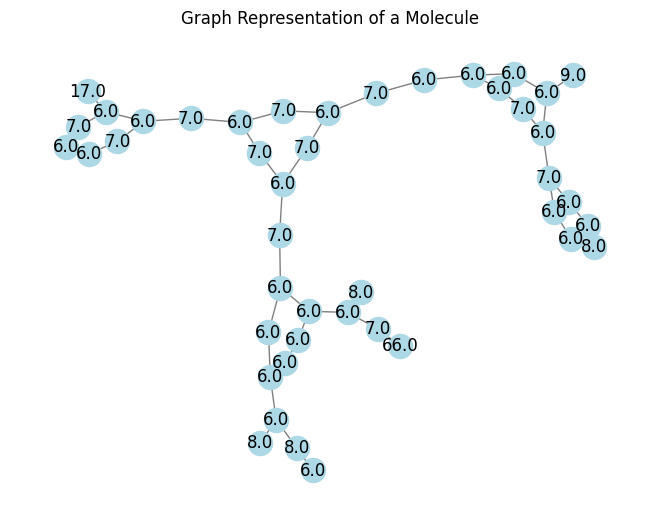

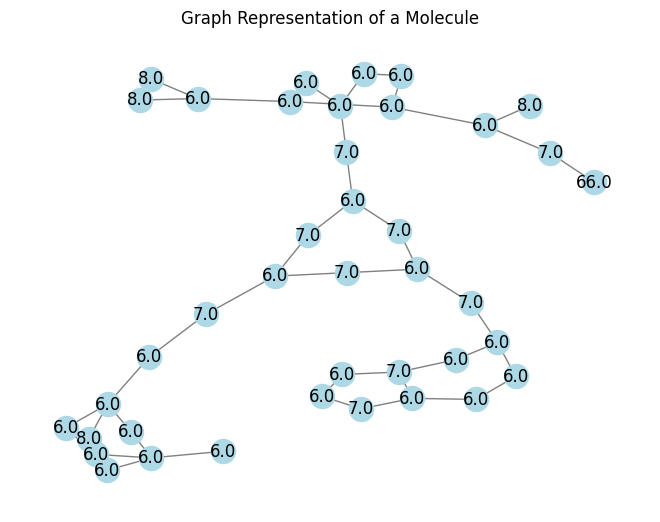

In [9]:
def visualize_graph(data):
    G = nx.Graph()
    x = data.x.numpy()
    edge_index = data.edge_index.numpy()
    for i, feature in enumerate(x):
        G.add_node(i, atom=feature[0], protein=feature[1])
    for i in range(edge_index.shape[1]):
        G.add_edge(edge_index[0, i], edge_index[1, i])
    pos = nx.spring_layout(G)
    node_labels = nx.get_node_attributes(G, 'atom')
    nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='lightblue', edge_color='gray')
    plt.title('Graph Representation of a Molecule')
    plt.show()

sample_data = df['graph'].sample(1).values[0]
visualize_graph(sample_data)

sample_test_data = test_df['graph'].sample(1).values[0]
visualize_graph(sample_test_data)